#Test many dither patterns#

This notebook is intended to demonstrate the various 'stock' dithering patterns available through MAF and then show how to use these dithering patterns to evaluate metrics under different dithering schemes.

This also provides an extended example of MAF [`Stackers`](https://confluence.lsstcorp.org/display/SIM/MAF+Stackers) which allow the addition of 'virtual' columns to the Opsim data, by generating these additional columns on the fly. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots

---

#Demonstrate the dithering patterns#

Here is an overview of the available dithering patterns. First - a list of the 'stock' dithering patterns available from MAF, along with their docstrings.

In [3]:
# Grab all the dither stackers from the stock stackers (rather than all stackers)
import inspect
ditherStackerList = []
for name, s in inspect.getmembers(stackers):
    if inspect.isclass(s):
        if 'Dither' in s.__name__:
            ditherStackerList.append(s)

In [4]:
# Print their docstrings
for s in ditherStackerList:
    print '-- ', s.__name__, ' --'
    print s.__doc__
    print '    Generates columns named', s().colsAdded
    print ' '

--  NightlyRandomDitherStacker  --

    Randomly dither the RA and Dec pointings up to maxDither degrees from center, one dither offset per night.
    
    Generates columns named ['nightlyRandomRADither', 'nightlyRandomDecDither']
 
--  NightlySequentialHexDitherStacker  --

    Use offsets from the hexagonal grid of 'hexdither', but visit each vertex sequentially.
    Sequential offset for each night of visits.
    
    Generates columns named ['nightlySequentialHexRADither', 'nightlySequentialHexDecDither']
 
--  NightlySpiralDitherStacker  --

    Offset along an equidistant spiral with numPoints, out to a maximum radius of maxDither.
    Sequential offset for each night of visits to a field.
    
    Generates columns named ['nightlySpiralRADither', 'nightlySpiralDecDither']
 
--  RandomDitherStacker  --

    Randomly dither the RA and Dec pointings up to maxDither degrees from center, different offset per visit.
    
    Generates columns named ['randomRADither', 'randomDecDither

Note that the 'nightly' versions of the stackers apply the same dither to all observations of a particular field taken in a single night (but may vary from one field to the next), while the versions without 'nightly' apply a separate dither offset to each visit.

**Visualize the dither options:**
Just write a bit of code to make nice figures of the dithering patterns.

In [5]:
import numpy as np

In [6]:
def plotDither(ditherStacker, nvisits=1000):
    # Set up some 'data' on a single pointing to dither
    fieldIds = np.ones(nvisits, int)
    fieldRA = np.zeros(nvisits, float) + np.radians(10.0)
    fieldDec = np.zeros(nvisits, float) 
    night = np.arange(0, nvisits/2.0, 0.5)
    night = np.floor(night) 
    simdata = np.core.records.fromarrays([fieldIds, fieldRA, fieldDec, night], 
                                         names = ['fieldID', 'fieldRA', 'fieldDec', 'night'])
    # Apply the stacker. 
    simdata = ditherStacker.run(simdata)
    
    fig = plt.figure()
    plt.axis('equal')
    # Draw a point for the center of the FOV.
    x = np.degrees(simdata['fieldRA'][0])
    y = np.degrees(simdata['fieldDec'][0])
    plt.plot(x, y, 'g+')
    # Draw a circle approximately the size of the FOV.
    stepsize = np.pi/50.
    theta = np.arange(0, np.pi*2.+stepsize, stepsize)
    radius = 1.75
    plt.plot(radius*np.cos(theta)+x, radius*np.sin(theta)+y, 'g-')
    # Draw the dithered pointings.
    x = np.degrees(simdata[s.colsAdded[0]])
    y = np.degrees(simdata[s.colsAdded[1]])
    plt.plot(x, y, 'k-', alpha=0.2)
    plt.plot(x, y, 'r.')
    plt.title(s.__class__.__name__)

Look at the default dither patterns.

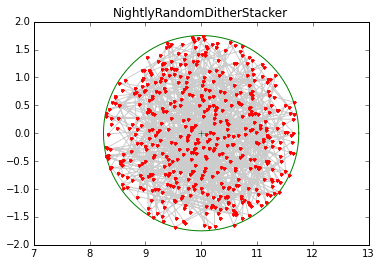

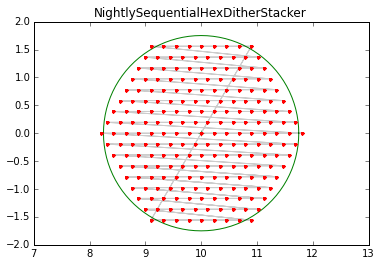

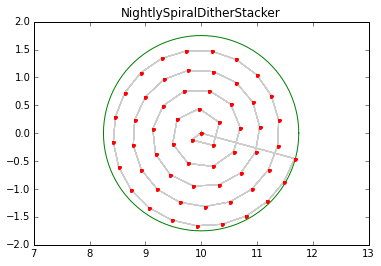

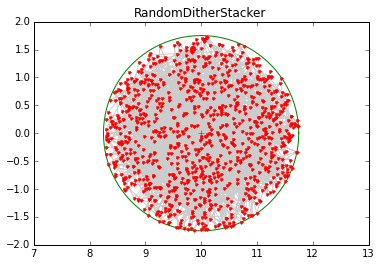

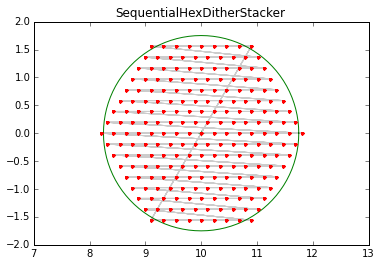

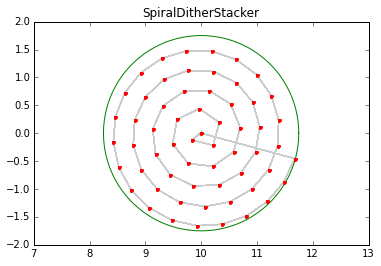

In [7]:
for ditherStacker in ditherStackerList:
    s = ditherStacker()
    plotDither(s)

Example comparison of 'Nightly' spiral dither (one offset applied per night) vs. spiral dither (one offset applied per visit).

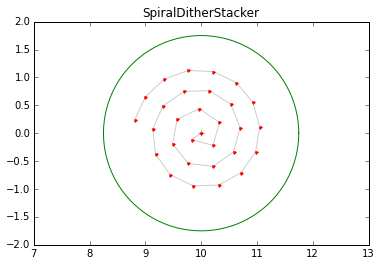

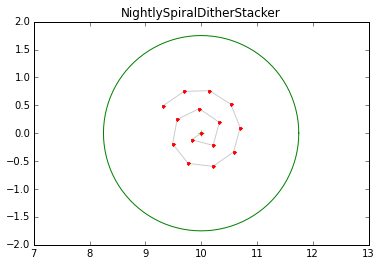

In [8]:
s = stackers.SpiralDitherStacker()
plotDither(s, nvisits=30)
s = stackers.NightlySpiralDitherStacker()
plotDither(s, nvisits=30)

Look at the dither patterns after some additional configuration (such as setting the random seed or changing the maxDither). 

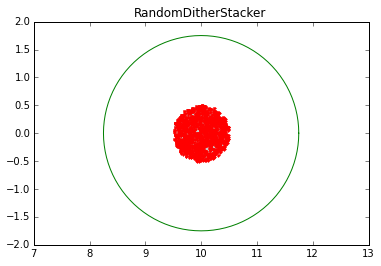

In [9]:
s = stackers.RandomDitherStacker(maxDither=0.5)
plotDither(s)

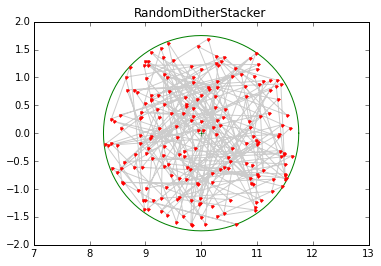

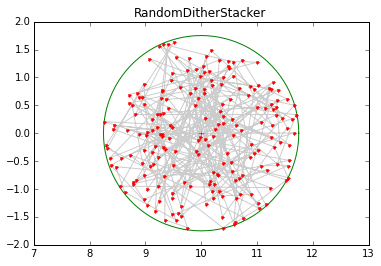

In [10]:
s = stackers.RandomDitherStacker(randomSeed=253)
plotDither(s, nvisits=200)
s = stackers.RandomDitherStacker(randomSeed=100)
plotDither(s, nvisits=200)

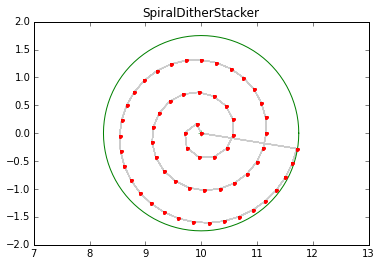

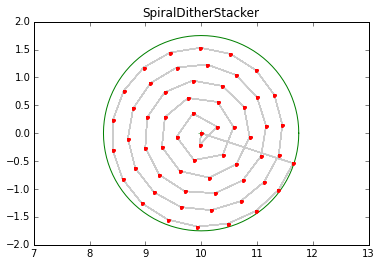

In [11]:
s = stackers.SpiralDitherStacker(nCoils=3)
plotDither(s)
s = stackers.SpiralDitherStacker(nCoils=6)
plotDither(s)

---
# Using the dither stackers #

We'll set up with a very simple metricbundle to just count the number of visits at each RA/Dec point in a healpix grid. To extend this to your own work, you could simply swap the metric to something more relevant. To speed up the notebook, run this example with a smaller nside (64?) to use a slightly lower resolution for the healpix slicer and only look at the first two years of visits. 

First, a metricbundle with no dithering.

In [12]:
nside = 128
metric = metrics.CountMetric('expMJD')
slicer0 = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec', nside=nside)  
#sqlconstraint = 'filter="r" and night<730' 
sqlconstraint = 'filter="r"'

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [13]:
myBundles = {}
myBundles['no dither'] = metricBundles.MetricBundle(metric, slicer0, sqlconstraint, 
                                                    runName='enigma_1189', metadata='no dither')

Next, a metricBundle using the built-in opsim hex-dither dithering. This dither pattern looks like the 'sequential dither pattern' above, but each offset is applied to *all* visits during a night (for all fields). The sequence along the vertices is controlled by the night %217 (the number of vertices), so some fields may never be offset at a particular vertex.

To use a different dither pattern to evaluate our metric, we simply change the values of ra/dec that the slicer is using to match visits to healpix grid points. 

In [14]:
slicer1 = slicers.HealpixSlicer(lonCol='ditheredRA', latCol='ditheredDec', nside=nside)
myBundles['hex dither'] = metricBundles.MetricBundle(metric, slicer1, sqlconstraint, runName='enigma_1189', 
                                                    metadata = 'hex dither')

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


If we want to use a stacker in its 'default' state, we can let MAF handle this internally, and we don't have to explicitly instantiate our stacker. We do have to use the exact column names that each stacker adds to the simData output (which you can see in the list of stackers and their docstrings, above). 

In [15]:
slicer2 = slicers.HealpixSlicer(lonCol='randomRADither', latCol='randomDecDither', nside=nside)
myBundles['random dither'] = metricBundles.MetricBundle(metric, slicer2, sqlconstraint, runName='enigma_1189',
                                                       metadata='random dither')

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


On the other hand, if we want to customize a stacker, we must explicitly instantiate it and pass it to the metricBundle.

In [16]:
stackerList = [stackers.NightlySpiralDitherStacker(nCoils=7)]
slicer3 = slicers.HealpixSlicer(lonCol='nightlySpiralRADither', latCol='nightlySpiralDecDither', nside=nside)
myBundles['spiral dither'] = metricBundles.MetricBundle(metric, slicer3, sqlconstraint, 
                                                       stackerList=stackerList, runName='enigma_1189',
                                                       metadata='spiral dither')

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Now, as before, we run this dictionary of metricBundles, using the MetricBundleGroup (note the sqlconstraint is the same for all these bundles). 

In [17]:
opsdb = db.OpsimDatabase('enigma_1189_sqlite.db')
outDir = 'dither_test'
resultsDb = db.ResultsDb(outDir=outDir)
bgroup = metricBundles.MetricBundleGroup(myBundles, opsdb, outDir=outDir, resultsDb=resultsDb)

(If we had previously calculated these metrics, but wanted to read them back in here to regenerate the plots, we'd do something like the next cell.)

In [18]:
#import os
#for b in bgroup.bundleDict.itervalues():
#    filename = os.path.join(outDir, b.fileRoot) + '.npz'
#    b.read(filename)

In [19]:
bgroup.runAll()

Querying database with constraint filter="r"
Found 544710 visits
Running:  ['spiral dither']
Completed metric generation.
Running:  ['random dither']
Completed metric generation.
Running:  ['hex dither']
Completed metric generation.
Running:  ['no dither']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3758: SAWarning: Textual SQL expression 'filter="r"' should be explicitly declared as text('filter="r"') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


We could just plot the individual skymap/histogram/power spectrum plots using bgroup.plotAll(), but here we'd prefer to get the individual skymaps, then a histogram and power spectrum using all the different metricBundles together.  In order to do that, we'll use the `PlotHandler` directly.

In [20]:
ph = plots.PlotHandler(outDir=outDir, resultsDb=resultsDb)

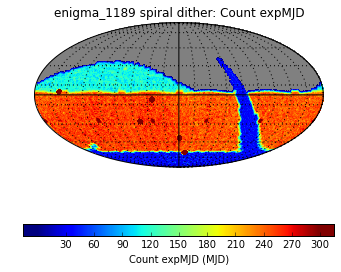

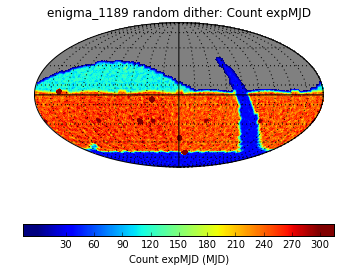

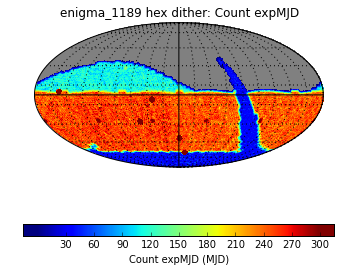

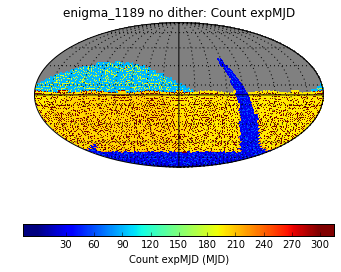

In [21]:
for mB in myBundles.itervalues():
    plotDict = {'xMin':0, 'xMax':300, 'colorMin':0, 'colorMax':300}
    mB.setPlotDict(plotDict)
    mB.plot(plotFunc=plots.HealpixSkyMap, plotHandler=ph)

1

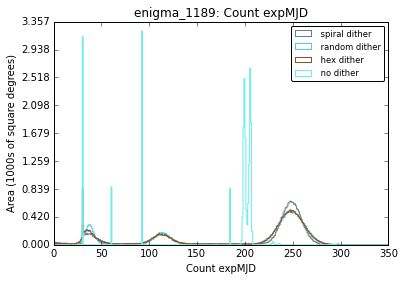

In [22]:
ph.setMetricBundles(myBundles)
# We must set a series of plotDicts: one per metricBundle. 
#  because we don't explicitly set the colors, they will be set randomly. 
plotDict = {'binsize':1, 'xMin':0, 'xMax':350}
ph.plot(plots.HealpixHistogram(), plotDicts=plotDict)

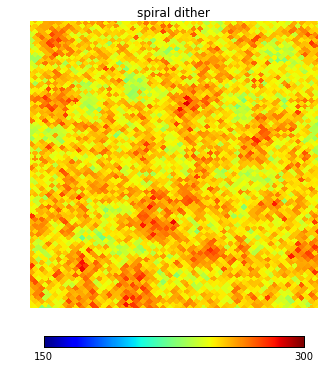

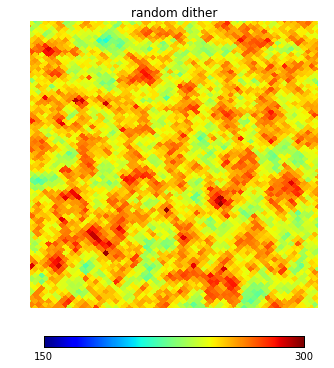

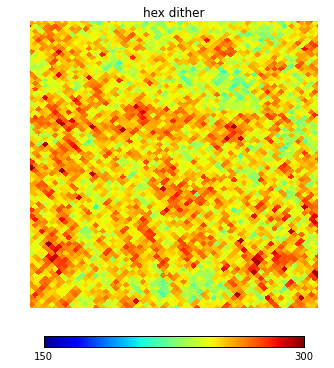

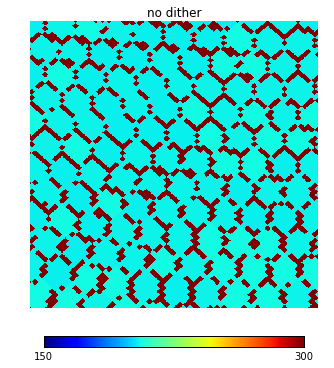

In [24]:
# Plot some close-ups.
import healpy as hp
for mB in myBundles.itervalues():
    hp.cartview(mB.metricValues, lonra=[70, 100], latra=[-30, -0], min=150., max=300., 
            flip='astro', title=mB.metadata)

For some purposes, examining the angular power spectra (and the power in the power spectra) is important. In practice, this likely requires some masking of the metric data (to remove ringing near the edges of the dithering and from the lower number of visits/depth from the areas in the survey outside the WFD region). But, after this masking is done (see the science notebook [GalaxyCounts](../science/static/GalaxyCounts.ipynb) as an example), generating plots of the power spectra labelled with total power could be done as follows.

In [25]:
summaryMetrics = [metrics.TotalPowerMetric()]
for mB in myBundles.itervalues():
    mB.setSummaryMetrics(summaryMetrics)
    mB.computeSummaryStats()
    plotDict = {'label':'%s : %g' %(mB.metadata, mB.summaryValues['TotalPower'])}
    mB.setPlotDict(plotDict)

monopole: 181.826  dipole: lon: 66.0516, lat: -60.6313, amp: 43.2375
monopole: 178.833  dipole: lon: 68.8512, lat: -61.7324, amp: 48.3458
monopole: 180.35  dipole: lon: 66.7455, lat: -61.1079, amp: 45.6123
monopole: 191.81  dipole: lon: 60.9552, lat: -51.5504, amp: 27.362


1

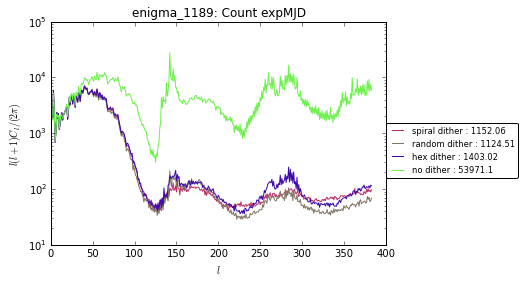

In [26]:
ph.plot(plots.HealpixPowerSpectrum(), plotDicts={'legendloc':(1, 0.3)})